每个状态的传感器范围初始化为原始计算得到的范围。
对于每个传感器，检查当前状态范围是否与其他状态的范围有重叠。
如果有重叠，调整当前状态的范围，确保不与其他状态的范围重叠。
更新后的范围将用于绘图和显示。

Calculated Ranges for status down_noconcat: {'sensor1': (2551.0, 2629.85), 'sensor2': (2639.0, 2888.0), 'sensor3': (2605.0, 2741.0), 'sensor4': (2556.0, 2673.0)}
Calculated Ranges for status left_noconcat: {'sensor1': (2564.8, 2734.0), 'sensor2': (2600.0, 2785.0), 'sensor3': (2517.0, 2517.0), 'sensor4': (2536.0, 2575.0)}
Calculated Ranges for status right_noconcat: {'sensor1': (2526.0, 2556.0), 'sensor2': (2570.0, 2774.0), 'sensor3': (2674.0, 2994.0), 'sensor4': (2590.0, 2848.0)}
Calculated Ranges for status up_noconcat: {'sensor1': (2541.0, 2578.75), 'sensor2': (2561.0, 2742.0), 'sensor3': (2595.0, 2714.25), 'sensor4': (2536.0, 2585.0)}


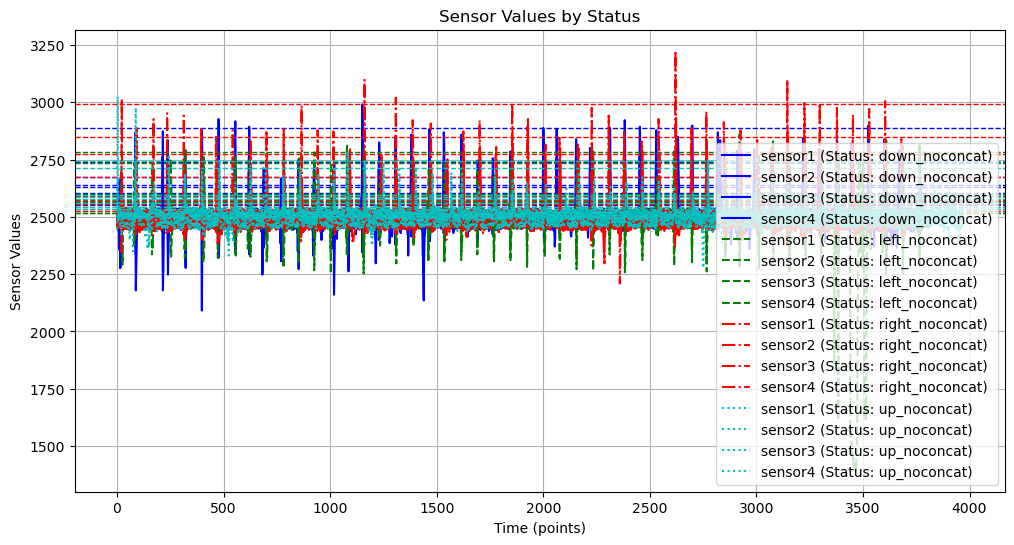

In [3]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.backends.backend_tkagg import FigureCanvasTkAgg, NavigationToolbar2Tk
from collections import defaultdict
import os

class SensorAnalyzer:
    def __init__(self, master):
        self.master = master
        self.master.title("CSV File Opener")
        
        self.column_names = ['sensor1', 'sensor2', 'sensor3', 'sensor4']
        self.selected_sensors = {name: tk.BooleanVar(value=True) for name in self.column_names}
        
        self.filepaths = []
        self.data = []
        self.ranges = defaultdict(dict)
        
        self.create_widgets()
        
    def create_widgets(self):
        btn_open = tk.Button(self.master, text="Open CSV Files", command=self.open_files)
        btn_open.pack(pady=10)
        
        self.checkbox_frame = tk.Frame(self.master)
        self.checkbox_frame.pack()
        
        for sensor in self.column_names:
            chk = tk.Checkbutton(self.checkbox_frame, text=sensor, variable=self.selected_sensors[sensor], command=self.update_plot)
            chk.pack(side=tk.LEFT)
        
        self.plot_frame = tk.Frame(self.master)
        self.plot_frame.pack(fill=tk.BOTH, expand=True)
        
        self.canvas = None
        self.toolbar = None
    
    def open_files(self):
        self.filepaths = filedialog.askopenfilenames(filetypes=[("CSV files", "*.csv")])
        if not self.filepaths:
            return
        
        self.data = [pd.read_csv(filepath) for filepath in self.filepaths]
        for i, filepath in enumerate(self.filepaths):
            df = self.data[i]
            df.columns = self.column_names
            status = os.path.splitext(os.path.basename(filepath))[0]  # Extract status from filename
            self.calculate_ranges(df, status)
        
        self.update_plot()
    
    def calculate_ranges(self, df, status):
        for sensor in self.column_names:
            baseline = df[sensor].median()
            std_dev = df[sensor].std()
            threshold = baseline + 2 * std_dev
            
            impulses = df[sensor][df[sensor] > threshold]
            if not impulses.empty:
                lower = impulses.quantile(0.05)
                upper = impulses.quantile(0.95)
                self.ranges[status][sensor] = (lower, upper)
            else:
                self.ranges[status][sensor] = (baseline, baseline)
        print(f"Calculated Ranges for status {status}:", self.ranges[status])
    
    def update_plot(self):
        if not self.filepaths:
            return
        
        if self.canvas:
            self.canvas.get_tk_widget().pack_forget()
            self.toolbar.pack_forget()
        
        fig, ax = plt.subplots(figsize=(12, 6))
        
        colors = ['b', 'g', 'r', 'c']
        linestyles = ['-', '--', '-.', ':']
        
        for i, df in enumerate(self.data):
            status = os.path.splitext(os.path.basename(self.filepaths[i]))[0]
            for sensor in self.column_names:
                if self.selected_sensors[sensor].get():
                    ax.plot(df[sensor], label=f'{sensor} (Status: {status})', color=colors[i % len(colors)], linestyle=linestyles[i % len(linestyles)], picker=5)
                    lower, upper = self.ranges[status][sensor]
                    ax.axhline(lower, color=colors[i % len(colors)], linestyle='--', linewidth=1)
                    ax.axhline(upper, color=colors[i % len(colors)], linestyle='--', linewidth=1)
        
        ax.set_title('Sensor Values by Status')
        ax.set_xlabel('Time (points)')
        ax.set_ylabel('Sensor Values')
        ax.legend()
        ax.grid(True)
        
        fig.canvas.mpl_connect('pick_event', self.onpick)
        fig.canvas.mpl_connect('scroll_event', self.zoom)
        
        self.canvas = FigureCanvasTkAgg(fig, master=self.plot_frame)
        self.canvas.draw()
        self.canvas.get_tk_widget().pack(side=tk.TOP, fill=tk.BOTH, expand=True)
        
        self.toolbar = NavigationToolbar2Tk(self.canvas, self.plot_frame)
        self.toolbar.update()
        self.toolbar.pack(side=tk.TOP, fill=tk.BOTH, expand=True)
    
    def onpick(self, event):
        ind = event.ind
        sensor_data = ""
        for i in ind:
            sensor_data += f"{event.artist.get_label()}: {event.artist.get_ydata()[i]}\n"
        messagebox.showinfo("Sensor Data", sensor_data)
    
    def zoom(self, event):
        base_scale = 1.1
        ax = event.inaxes
        cur_xlim = ax.get_xlim()
        cur_ylim = ax.get_ylim()
        xdata = event.xdata
        ydata = event.ydata
        if event.button == 'up':
            scale_factor = 1 / base_scale
        elif event.button == 'down':
            scale_factor = base_scale
        else:
            scale_factor = 1
        
        new_width = (cur_xlim[1] - cur_xlim[0]) * scale_factor
        new_height = (cur_ylim[1] - cur_ylim[0]) * scale_factor
        
        relx = (cur_xlim[1] - xdata) / (cur_xlim[1] - cur_xlim[0])
        rely = (cur_ylim[1] - ydata) / (cur_ylim[1] - cur_ylim[0])
        
        ax.set_xlim([xdata - new_width * (1 - relx), xdata + new_width * relx])
        ax.set_ylim([ydata - new_height * (1 - rely), ydata + new_height * rely])
        ax.figure.canvas.draw()

root = tk.Tk()
app = SensorAnalyzer(root)
root.mainloop()


## 生成YAML文件

In [6]:
import yaml
import re

# 输入的字符串
input_string = """
Calculated Ranges for status down_noconcat: {'sensor1': (2551.0, 2629.85), 'sensor2': (2639.0, 2888.0), 'sensor3': (2605.0, 2741.0), 'sensor4': (2556.0, 2673.0)}
Calculated Ranges for status left_noconcat: {'sensor1': (2564.8, 2734.0), 'sensor2': (2600.0, 2785.0), 'sensor3': (2517.0, 2517.0), 'sensor4': (2536.0, 2575.0)}
Calculated Ranges for status right_noconcat: {'sensor1': (2526.0, 2556.0), 'sensor2': (2570.0, 2774.0), 'sensor3': (2674.0, 2994.0), 'sensor4': (2590.0, 2848.0)}
Calculated Ranges for status up_noconcat: {'sensor1': (2541.0, 2578.75), 'sensor2': (2561.0, 2742.0), 'sensor3': (2595.0, 2714.25), 'sensor4': (2536.0, 2585.0)}
"""

# 解析数据
pattern = r"status (\w+)_noconcat: ({.*?})"
parsed_data = re.findall(pattern, input_string)

# 数据转换为字典
status_dict = {}
for status, values in parsed_data:
    # 评估字典字符串
    sensor_values = eval(values)
    # 转换为整数并存储
    status_dict[status] = {k: {'min': int(v[0]), 'max': int(v[1])} for k, v in sensor_values.items()}

# 使用 YAML 格式化并打印到终端
yaml_content = yaml.dump(status_dict, default_flow_style=False)
print(yaml_content)


down:
  sensor1:
    max: 2629
    min: 2551
  sensor2:
    max: 2888
    min: 2639
  sensor3:
    max: 2741
    min: 2605
  sensor4:
    max: 2673
    min: 2556
left:
  sensor1:
    max: 2734
    min: 2564
  sensor2:
    max: 2785
    min: 2600
  sensor3:
    max: 2517
    min: 2517
  sensor4:
    max: 2575
    min: 2536
right:
  sensor1:
    max: 2556
    min: 2526
  sensor2:
    max: 2774
    min: 2570
  sensor3:
    max: 2994
    min: 2674
  sensor4:
    max: 2848
    min: 2590
up:
  sensor1:
    max: 2578
    min: 2541
  sensor2:
    max: 2742
    min: 2561
  sensor3:
    max: 2714
    min: 2595
  sensor4:
    max: 2585
    min: 2536



未用算法区分

In [2]:
def check_all_states(sensor_values, all_state_ranges):
    """
    Check all states to see if the provided sensor values match any state ranges and return all matching states.
    
    :param sensor_values: Dictionary of sensor values e.g., {'S0': 1950, 'S1': 1900, 'S2': 1950, 'S3': 1850}
    :param all_state_ranges: Dictionary of all state ranges
    :return: List of all states that match the sensor values
    """
    matching_states = []
    for state, ranges in all_state_ranges.items():
        match = True
        for sensor, value in sensor_values.items():
            if sensor in ranges:
                lower, upper = ranges[sensor]
                if not (lower <= value <= upper):
                    match = False
                    break
        if match:
            matching_states.append(state)
    return matching_states

# Define ranges for each state based on your provided data
all_state_ranges = {
    'down': {'S0': (1886.0, 2010.9), 'S1': (1861.0, 1975.0), 'S2': (1892.0, 1975.0), 'S3': (1861.0, 1943.0)},
    'left': {'S0': (1937.0, 2134.0), 'S1': (1892.0, 2089.35), 'S2': (1899.0, 2034.1), 'S3': (1823.0, 1892.0)},
    'right': {'S0': (1905.0, 2111.85), 'S1': (1810.0, 2004.55), 'S2': (1905.0, 2064.0), 'S3': (1816.0, 1846.2)},
    'up': {'S0': (2064.0, 2749.4), 'S1': (1877.9, 2271.1), 'S2': (2031.7, 2877.65), 'S3': (1823.0, 1867.0)}
}

# Example sensor readings
sensor_readings = {'S0': 1950, 'S1': 1900, 'S2': 1950, 'S3': 1890}

# Check all states and print the result
matched_states = check_all_states(sensor_readings, all_state_ranges)
print("Matched States:", matched_states if matched_states else "No state matches the given sensor values")


Matched States: ['down', 'left']


采用滑动窗口

In [ ]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
from collections import deque, defaultdict
import numpy as np

# 状态范围定义
status_ranges = {
    'down': {'s0': (1886.0, 2010.9), 's1': (1861.0, 1975.0), 's2': (1892.0, 1975.0), 's3': (1861.0, 1943.0)},
    'left': {'s0': (1937.0, 2134.0), 's1': (1892.0, 2089.35), 's2': (1899.0, 2034.1), 's3': (1823.0, 1892.0)},
    'right': {'s0': (1905.0, 2111.85), 's1': (1810.0, 2004.55), 's2': (1905.0, 2064.0), 's3': (1816.0, 1846.2)},
    'up': {'s0': (2064.0, 2749.4), 's1': (1877.9, 2271.1), 's2': (2031.7, 2877.65), 's3': (1823.0, 1867.0)}
}

class SensorAnalyzerApp:
    def __init__(self, master):
        self.master = master
        master.title("Sensor Data Analyzer")
        
        # Setup UI
        self.label = tk.Label(master, text="Choose a CSV file to analyze:")
        self.label.pack()

        self.open_button = tk.Button(master, text="Open File", command=self.open_file)
        self.open_button.pack()

        self.result_label = tk.Label(master, text="")
        self.result_label.pack()

    def open_file(self):
        filepath = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if not filepath:
            return
        
        try:
            self.analyze_data(filepath)
        except Exception as e:
            messagebox.showerror("Error", f"Failed to read or process the file: {e}")

    def analyze_data(self, filepath):
        df = pd.read_csv(filepath, header=None)  # Assuming the CSV has no header row
        df.columns = ['s0', 's1', 's2', 's3']  # Set column names for easy reference

        status_count = self.process_data(df)
        result_text = "\n".join([f"{status}: {count}" for status, count in status_count.items()])
        self.result_label.config(text=f"Status counts:\n{result_text}")

    def process_data(self, sensor_data, window_size=30):
        window = {s: deque(maxlen=window_size) for s in status_ranges['down'].keys()}
        status_count = defaultdict(int)
        
        for _, row in sensor_data.iterrows():
            for sensor in window:
                window[sensor].append(row[sensor])
            
            if len(window['s0']) < window_size:
                continue
            
            max_values = {s: max(window[s]) for s in window}
            current_status_count = self.determine_status(max_values)
            
            for status, count in current_status_count.items():
                status_count[status] += count
        
        return status_count

    def determine_status(self, max_values):
        for status, ranges in status_ranges.items():
            if all(ranges[s][0] <= max_values[s] <= ranges[s][1] for s in max_values):
                return {status: 1}  # 返回一个包含单一状态的字典
        return {}  # 如果没有匹配的状态，返回一个空字典


root = tk.Tk()
app = SensorAnalyzerApp(root)
root.mainloop()


探究窗口大小

In [5]:
import tkinter as tk
from tkinter import filedialog, messagebox
import pandas as pd
from collections import deque, defaultdict
import numpy as np
import os

# 状态范围定义
status_ranges = {
    'down': {'s0': (1886.0, 2010.9), 's1': (1861.0, 1975.0), 's2': (1892.0, 1975.0), 's3': (1861.0, 1943.0)},
    'left': {'s0': (1937.0, 2134.0), 's1': (1892.0, 2089.35), 's2': (1899.0, 2034.1), 's3': (1823.0, 1892.0)},
    'right': {'s0': (1905.0, 2111.85), 's1': (1810.0, 2004.55), 's2': (1905.0, 2064.0), 's3': (1816.0, 1846.2)},
    'up': {'s0': (2064.0, 2749.4), 's1': (1877.9, 2271.1), 's2': (2031.7, 2877.65), 's3': (1823.0, 1867.0)}
}

class SensorAnalyzerApp:
    def __init__(self, master):
        self.master = master
        master.title("Sensor Data Analyzer")
        
        # Setup UI
        self.label = tk.Label(master, text="Choose CSV files to analyze:")
        self.label.pack()

        self.open_button = tk.Button(master, text="Open Files", command=self.open_files)
        self.open_button.pack()

        self.result_label = tk.Label(master, text="")
        self.result_label.pack()

    def open_files(self):
        filepaths = filedialog.askopenfilenames(filetypes=[("CSV files", "*.csv")])
        if not filepaths:
            return

        window_sizes = range(10, 51, 5)  # Test window sizes from 10 to 50, increment by 5
        for window_size in window_sizes:
            accuracy_results, total_recognized_points = self.analyze_data(filepaths, window_size)
            print(f"Window Size {window_size} Results:")
            for filepath in filepaths:
                print(f"{os.path.basename(filepath)} - Accuracy: {accuracy_results[filepath]:.2f}%, Recognized Points: {total_recognized_points[filepath]}")
            print("\n")  # Add a newline for better readability between different window sizes

    def analyze_data(self, filepaths, window_size):
        accuracy_results = {}
        total_recognized_points = {}
        for filepath in filepaths:
            df = pd.read_csv(filepath, header=None)
            df.columns = ['s0', 's1', 's2', 's3']
            status_count, recognized_points = self.process_data(df, window_size)

            expected_status = os.path.splitext(os.path.basename(filepath))[0].split('_')[0]
            total_counts = sum(status_count.values())
            correct_count = status_count.get(expected_status, 0)
            accuracy = (correct_count / total_counts) * 100 if total_counts else 0
            accuracy_results[filepath] = accuracy
            total_recognized_points[filepath] = recognized_points

        return accuracy_results, total_recognized_points

    def process_data(self, sensor_data, window_size):
        window = {s: deque(maxlen=window_size) for s in status_ranges['down'].keys()}
        status_count = defaultdict(int)
        recognized_points = 0
        
        for _, row in sensor_data.iterrows():
            for sensor in window:
                window[sensor].append(row[sensor])
            
            if len(window['s0']) < window_size:
                continue
            
            max_values = {s: max(window[s]) for s in window}
            current_status_count = self.determine_status(max_values)
            
            if current_status_count:
                recognized_points += 1
                for status, count in current_status_count.items():
                    status_count[status] += count
        
        return status_count, recognized_points

    def determine_status(self, max_values):
        for status, ranges in status_ranges.items():
            if all(ranges[s][0] <= max_values[s] <= ranges[s][1] for s in max_values):
                return {status: 1}  # Return a dictionary with one valid status
        return {}  # Return an empty dictionary if no status is matched

root = tk.Tk()
app = SensorAnalyzerApp(root)
root.mainloop()


Exception in Tkinter callback
Traceback (most recent call last):
  File "C:\Users\TC\.conda\envs\scientificAnalysis\Lib\tkinter\__init__.py", line 1967, in __call__
    return self.func(*args)
           ^^^^^^^^^^^^^^^^
  File "C:\Users\TC\AppData\Local\Temp\ipykernel_4872\2229765800.py", line 37, in open_files
    accuracy_results, total_recognized_points, peak_orders = self.analyze_data(filepaths, window_size)
                                                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\TC\AppData\Local\Temp\ipykernel_4872\2229765800.py", line 52, in analyze_data
    status_count, recognized_points, order = self.process_data(df, window_size, expected_status)
                                             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\TC\AppData\Local\Temp\ipykernel_4872\2229765800.py", line 82, in process_data
    if self.determine_status({s: max(window[s]) for s in window}, expected_status):
       ^^^^^

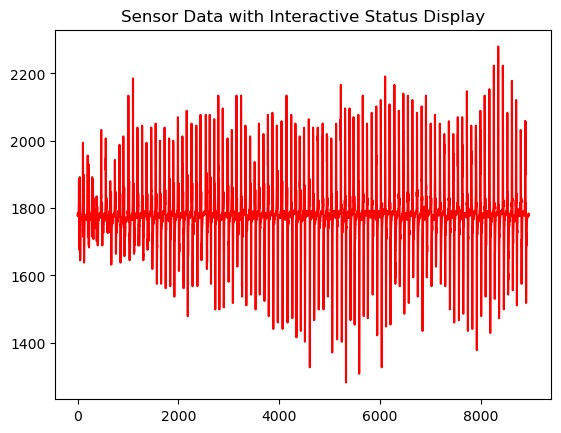

In [37]:
import tkinter as tk
from tkinter import filedialog
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.widgets import SpanSelector

# 状态范围定义
status_ranges = {
    'down': {'s0': (1886.0, 2010.9), 's1': (1861.0, 1975.0), 's2': (1892.0, 1975.0), 's3': (1861.0, 1943.0)},
    'left': {'s0': (1937.0, 2134.0), 's1': (1892.0, 2089.35), 's2': (1899.0, 2034.1), 's3': (1823.0, 1892.0)},
    'right': {'s0': (1905.0, 2111.85), 's1': (1810.0, 2004.55), 's2': (1905.0, 2064.0), 's3': (1816.0, 1846.2)},
    'up': {'s0': (2064.0, 2749.4), 's1': (1877.9, 2271.1), 's2': (2031.7, 2877.65), 's3': (1823.0, 1867.0)}
}

class SensorAnalyzerApp:
    def __init__(self, master):
        self.master = master
        master.title("Sensor Data Analyzer")

        # Setup UI
        self.label = tk.Label(master, text="Choose a CSV file to analyze:")
        self.label.pack()

        self.open_button = tk.Button(master, text="Open File", command=self.open_file)
        self.open_button.pack()

    def open_file(self):
        filepath = filedialog.askopenfilename(filetypes=[("CSV files", "*.csv")])
        if not filepath:
            return

        self.analyze_data(filepath)

    def analyze_data(self, filepath):
        df = pd.read_csv(filepath, header=None)
        df.columns = ['s0', 's1', 's2', 's3']

        t = np.arange(0, len(df), 1)
        data = df['s0']  # 使用s0列数据

        fig, ax = plt.subplots()
        line, = ax.plot(t, data, 'r')
        ax.set_title('Sensor Data with Interactive Status Display')
        status_text = ax.text(0.05, 0.95, '', transform=ax.transAxes)

        def determine_status(max_values):
            for status, ranges in status_ranges.items():
                if all(ranges[s][0] <= max_values[s] <= ranges[s][1] for s in max_values):
                    return status
            return 'unknown'

        def onselect(xmin, xmax):
            indmin, indmax = np.searchsorted(t, (xmin, xmax))
            indmax = min(len(t) - 1, indmax)

            thisx = t[indmin:indmax]
            thisy = data[indmin:indmax]
            line.set_data(thisx, thisy)
            ax.set_xlim(thisx[0], thisx[-1])
            ax.set_ylim(thisy.min(), thisy.max())

            window_data = df.iloc[indmin:indmax + 1]
            max_values = {s: window_data[s].max() for s in ['s0', 's1', 's2', 's3']}
            current_status = determine_status(max_values)
            status_text.set_text(f"Current Status: {current_status}")
            fig.canvas.draw()

        span = SpanSelector(ax, onselect, 'horizontal', useblit=True)

        plt.show()

root = tk.Tk()
app = SensorAnalyzerApp(root)
root.mainloop()
